# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, random, shutil
import copy

# Torch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image

### Dividing Dataset (60% training, 20% validation, 20% testing)

In [3]:
def img_train_val_test_split(root_dir):
    """
    This function splits a folder with subfolders into train, test and validation datasets,
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images,
    :return: None
    """
    # A list of strings of subfolder names
    classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']

    # Ratio of validation and test datasets
    val_ratio = 0.20
    test_ratio = 0.20

    for cls in classes_dir:
        # Create Train / Val / Test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'val/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # Get pathname of cls
        src = root_dir + cls  # Folder to copy images from

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])
       
        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new validation folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'val/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
        
    return None

In [4]:
# root_dir: filepath of coad_msi_mss (cancer datasets) with '/' at the back
# root_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

#root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'
#root_dir = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/'
root_dir = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/'

In [4]:
img_train_val_test_split(root_dir)

### Preprocessing: Data Augmentation and Normalization

In [5]:
# SOURCE: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Preprocessing of Images for Training and Validation datasets.
# For training, data augmentation and normalization
# For validation, only normalization
data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# Set directory of training dataset
#root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/train'
#root_dir_train = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/train'
root_dir_train = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/train'

#root_dir_train = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

# Set directory of validation dataset
# root_dir_val = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/val'
# root_dir_val = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/val'
root_dir_val = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/val'

#root_dir_test = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'

In [6]:
# Apply preprocessing to training and validation datasets using root directory and transformations specified
train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
val_image_dataset = datasets.ImageFolder(root = root_dir_val, transform=data_transformation_val)

### Prepare DataLoader for training and validation datasets

In [7]:
trainloader = DataLoader(train_image_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_image_dataset, batch_size=64, shuffle=True)

### Data Visualization (Display some images)

In [8]:
# Get class names (MSIMUT, MSS)
class_names = trainloader.dataset.classes

def show_images(images, labels, preds):
    """
    This function displays the images to provide a visualization of the data augmentations done on the training
    dataset.
    :param images: The current DataLoader of the image at which data augmentation has been done
    :param labels: The current label of the image
    :param preds: The predicted label of the image in training dataset
    :return: a subplot of 1 by 6 cancer images with their labels and predicted labels
    """
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            
            # Convert to from tensor to numpy
            # Take its transpose because
            # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
            image = image.numpy().transpose((1, 2, 0))  # Set axes
            
            # Images were normalised earlier.
            # To show the image denormalise the images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)
            
            colour = 'green' if preds[i] == labels[i] else 'red'
            
            plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
        
    plt.tight_layout()
    plt.show()

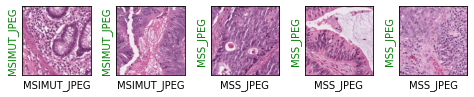

In [9]:
# Retrieve batch of training data
images, labels = next(iter(trainloader))

# Since predictions are not available for training data yet
# Labels are used in place of predictions
show_images(images, labels, labels)

### Creating Model - Load resnet18

In [10]:
# Load resnet18 pre-trained model
resnet18 = models.resnet18(pretrained=True)

# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Freeze parameters so we don't backprop through them
for param in resnet18.parameters():
    param.requires_grad = False
    
# Classifier architecture to put on top of resnet18
num_ftrs = resnet18.fc.in_features

# Set size of output samples (We only have 2 classes, so out_features = 2)
resnet18.fc = nn.Linear(num_ftrs, out_features=2)

# Set criterion of model (loss function)
criterion = nn.CrossEntropyLoss()

# Set Optimizer parameters - make sure all parameters are being optimized
# optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Send resnet18 model to GPU
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
class_names2 = trainloader.dataset.classes

def show_images2(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
                
            # Convert to from tensor to numpy
            # Take its transpose because
            # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
            image = image.numpy().transpose((1, 2, 0))  # Set axes
                
            # Images were normalised earlier.
            # To show the image denormalise the images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
                
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)

            if preds[i] == 2:
                p = 1
            else:
                p = 0
            colour = 'green' if p == labels[i] else 'red'
                
            plt.xlabel(f'{class_names2[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names2[p]}', color=colour)
        
    plt.tight_layout()
    plt.show()

In [ ]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(valloader))
    outputs = resnet18(images)
    _ , preds = torch.max(outputs, 1)
    #print(labels)
    show_images2(images, labels, preds)

In [ ]:
show_preds()

### Training Model

In [12]:
# Note training losses and acc, alongside validation losses and acc for visualization after training
train_losses = []
train_acc = []

val_losses = []
val_acc = []

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    """
    This function trains the current model, each epoch has a training and validation phase
    :param model: The current resnet18 model loaded 
    :param criterion: Criterion set to the model
    :param optimizer: The optimizer parameter of the model
    :param scheduler: LR Scheduler Object
    :param num_epochs: Number of epochs the train_model function is going to run for
    :return: Each epoch with a training and validation loss, alongside their accuracy and saves the best
    model with highest accuracy
    """

    # Take note of time
    since = time.time()
    
    # Deep copy the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Run for num_epochs times
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('--' * 5)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                condition = trainloader
                size = len(train_image_dataset)
            else:
                condition = valloader
                size = len(val_image_dataset)

            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in condition:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Set number of epochs to train
num_epochs = 10

# Call train_model function with the model, criterion, optimizer, scheduler and number of epochs as parameters
model_resnet18 = train_model(resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 1/10
----------


C:\Users\jones\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\jones\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6808 Acc: 0.5943
val Loss: 0.6360 Acc: 0.6427

Epoch 2/10
----------
train Loss: 0.6271 Acc: 0.6520
val Loss: 0.6299 Acc: 0.6510

Epoch 3/10
----------
train Loss: 0.6117 Acc: 0.6754
val Loss: 0.6107 Acc: 0.6667

Epoch 4/10
----------
train Loss: 0.5919 Acc: 0.6855
val Loss: 0.6064 Acc: 0.6768

Epoch 5/10
----------
train Loss: 0.5886 Acc: 0.6873
val Loss: 0.6030 Acc: 0.6750

Epoch 6/10
----------
train Loss: 0.5867 Acc: 0.6944
val Loss: 0.6054 Acc: 0.6722

Epoch 7/10
----------
train Loss: 0.5718 Acc: 0.7015
val Loss: 0.5980 Acc: 0.6805

Epoch 8/10
----------
train Loss: 0.5653 Acc: 0.7128
val Loss: 0.5960 Acc: 0.6878

Epoch 9/10
----------
train Loss: 0.5691 Acc: 0.7088
val Loss: 0.5980 Acc: 0.6860

Epoch 10/10
----------
train Loss: 0.5658 Acc: 0.7147
val Loss: 0.5970 Acc: 0.6796

Training complete in 2m 58s
Best val Acc: 0.687845


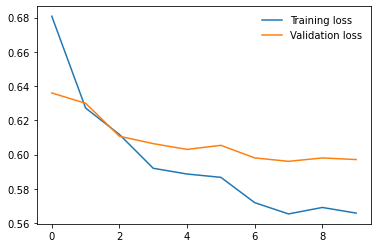

In [14]:
# Plot losses of training and validation 
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [15]:
# Save the best model
#torch.save(model_resnet18, '/Users/vionnietan/Desktop/FIT3163 - FIT3164/FIT3164/FIT3164/resnet18.pth')
torch.save(model_resnet18, 'C:/Users/jones/Desktop/FIT3164/22septmodel.pth')

In [ ]:
import pickle
filename = '18septmodel.sav'
pickle.dump(model_resnet18,open(filename,'wb'))

In [ ]:
pkl_filename = '18septmodel.pkl'
with open(pkl_filename,'wb') as file:
    pickle.dump(model_resnet18,file)

In [ ]:
with open('model/finalized_model.pkl','rb') as file:
    model = pickle.load(file)